In [1]:
import dipy

In [2]:
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs

In [3]:
from fenics import *
from mshr import *
#from math import pi, sin, cos, sqrt
import math
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import os
import subprocess

In [4]:
fname = 'dMRI_data/ms-ras_data.nii.gz' 
bval_fname = 'dMRI_data/ms-ras.bval' 
bvec_fname = 'dMRI_data/ms-ras.bvec'

data, affine = load_nifti(fname)
bvals, bvecs = read_bvals_bvecs(bval_fname, bvec_fname)
dims = data.shape
print('data.shape (%d, %d, %d, %d)' % dims)

data_float = data.astype(np.float32)

dataMaxVal = int(max(data.flatten()))
dataMinVal = int(min(data.flatten()))

print('b values: ', bvals)
print('b vectors: ', bvecs)

data.shape (104, 104, 72, 99)
b values:  [   0.  700.  700.  700.  700.  700.  700.  700.  700.  700.  700.  700.
  700.  700.  700.  700.  700.  700.  700.  700.  700.    0.  700.  700.
  700.  700.  700.  700.  700.  700.  700.  700. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000.    0. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000.    0. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
    0. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000.]
b vectors:  [[ 0.0000000e+00 -0.0000000e+00  0.0000000e+00]
 [ 2.2293058e-01  4.9968055e-01  8.3703119e-01]
 [-1.7871778e-01  4.9333411e-01  8.5128242e-01]
 [-3.7542525e-01  1.4225766e-01  9.1587037e-01]
 [ 4.1157657e-01  7.2193778e-01  5.5624700e-01]
 [ 1.9853516e-01  9.3616748e-01  2.9012811e-01]
 [ 8.4751403e-01  5.2907634e-01  4.2405690e-02]
 [ 7.39

In [5]:
parameters['allow_extrapolation'] = True

In [6]:
#Input volume number
k = 43

#B vector
b = 2000
b2000_indcs = np.where(bvals==b)
b0_inds = np.where(bvals==0)
b0_ind = b0_inds[0][0]

In [7]:
#To select well distruted (farthes pointing vectors in 3D)
def calc_distances(p0, points):
    return np.minimum(((p0 - points)**2).sum(axis=1), ((-p0 - points)**2).sum(axis=1))
    #return ((p0 - points)**2).sum(axis=1)
    
def farthestPts(pts, K):
    farthest_pts = np.zeros((K, 3))
    pts_inds = np.zeros(K)
    #farthest_pts[0] = pts[np.random.randint(len(pts))]
    farthest_pts[0] = pts[1]
    pts_inds[0] = 1
    distances = calc_distances(farthest_pts[0], pts)
    for i in range(1, K):
        farthest_pts[i] = pts[np.argmax(distances)]
        pts_inds[i] = np.argmax(distances)
        distances = np.minimum(distances, calc_distances(farthest_pts[i], pts))
    return farthest_pts, pts_inds
sub_bvecs, sub_indcs = farthestPts(bvecs[bvals==b], k)
print('b sub vectors: ', sub_bvecs)
#print('b sub vector indecs ', sub_indcs)

#Choose true indeces
true_sub_indcs = np.zeros(len(sub_indcs))
for i in range(len(sub_indcs)):
    true_sub_indcs[i] = b2000_indcs[0][int(sub_indcs[i])]
true_sub_indcs = np.append(true_sub_indcs, b0_ind)
sorted_true_sub_indcs = np.sort(true_sub_indcs)
#print('b sub vectors: ', sub_bvecs)
print('sorted b sub vector indeces ', sorted_true_sub_indcs)

b sub vectors:  [[-4.9948000e-04  9.9898493e-01  4.5043090e-02]
 [-9.9998999e-01 -3.9998800e-03  1.9999400e-03]
 [-2.4582910e-02  1.1101565e-01 -9.9351466e-01]
 [-5.6061244e-01 -6.2922853e-01  5.3831679e-01]
 [-4.5817986e-01 -5.9716052e-01 -6.5838480e-01]
 [-4.5601672e-01  6.9743240e-01 -5.5284446e-01]
 [-4.9492225e-01  6.7110866e-01  5.5196494e-01]
 [ 7.1813208e-01 -1.0619420e-02  6.9582558e-01]
 [ 5.7621109e-01 -7.1084380e-02 -8.1420386e-01]
 [ 7.6881015e-01  6.3443005e-01  8.0182670e-02]
 [ 7.2697550e-01 -6.8590748e-01 -3.2209960e-02]
 [ 1.5335634e-01 -4.8859259e-01 -8.5892904e-01]
 [ 1.2325888e-01  7.6308644e-01 -6.3443404e-01]
 [ 8.9393294e-01 -2.8159970e-01  3.4869114e-01]
 [-4.4222176e-01 -8.9561254e-01  4.8147070e-02]
 [ 1.0850769e-01  8.1606823e-01  5.6767851e-01]
 [ 7.8701800e-01  1.8293804e-01 -5.8918279e-01]
 [-8.9079481e-01  3.9080378e-01  2.3185565e-01]
 [ 4.1972056e-01  1.3890146e-01  8.9696217e-01]
 [ 7.5508285e-01  3.9112961e-01  5.2618176e-01]
 [-2.3356465e-01  9.1487

In [8]:
# Selecting one b0 and k+7 b700 voxels
sorted_true_sub_indcs = sorted_true_sub_indcs.astype(int)
sub_bvals = bvals[sorted_true_sub_indcs]
print(sub_bvals)

sub_data = data_float[:, :, :, sorted_true_sub_indcs]
print(sub_data.shape)

[   0. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.]
(104, 104, 72, 44)


In [9]:
##Registration
#b0_ind = np.where(sub_bvals==0)[0]
#regis_sub_data = subprocess.run(["eddy_correct", "cosine_weighted_averaging/sub_vols.nii.gz", "cosine_weighted_averaging/registered_data/sub_data_lowb-corrected.nii.gz", str(b0_ind[0])])
#print("The exit code was: %d" % regis_sub_data.returncode)

In [10]:
##Load registrated data
#nameStr = 'LH_all_voxels/multi_shell_registerered_data/kFrame_correct54.nii.gz'     
#sub_regis_data, sub_regis_affine = load_nifti(nameStr)
#dims_sub = sub_regis_data.shape
#print('data.shape (%d, %d, %d, %d)' % sub_regis_data.shape)
#print('Type: ', sub_regis_data.dtype)

In [11]:
#Volume Index to predict
nextIter_sub_bvecs, nextIter_sub_indcs = farthestPts(bvecs[bvals==b], k+1)
nextIter_true_sub_indcs = np.zeros(len(nextIter_sub_indcs))
for i in range(len(nextIter_sub_indcs)):
    nextIter_true_sub_indcs[i] = b2000_indcs[0][int(nextIter_sub_indcs[i])]
nextIter_true_sub_indcs = np.append(nextIter_true_sub_indcs, b0_ind)
sorted_nextIter_true_sub_indcs = np.sort(nextIter_true_sub_indcs)
print('b sub vector indecs ', sorted_nextIter_true_sub_indcs)
nextIter_sub_indcs = sorted_nextIter_true_sub_indcs.astype(int)
    
inter_sub_indcs = [i for i in sorted_nextIter_true_sub_indcs if i not in sorted_true_sub_indcs]
if len(inter_sub_indcs) != 0: 
    left_indcs = inter_sub_indcs[0]
else:
    left_indcs = np.arange(data.shape[3])
    left_indcs = np.delete(left_indcs, sorted_true_sub_indcs)
    print(left_indcs)
    left_indcs = left_indcs[0]
left_indcs = left_indcs.astype(int)
print("Predicted volume: ", left_indcs)

b sub vector indecs  [ 0. 32. 33. 36. 37. 39. 40. 44. 45. 46. 47. 49. 52. 53. 54. 55. 60. 61.
 62. 64. 65. 66. 67. 70. 71. 72. 73. 74. 76. 77. 78. 80. 82. 83. 85. 86.
 87. 88. 89. 90. 92. 93. 94. 97. 98.]
Predicted volume:  40


In [12]:
#center = Point(0.0, 0.0, 0.0)
#sphere = Sphere(center,1.0)
#mesh = generate_mesh(sphere,5) # 20 specify the resolution of the mesh
#plot(mesh)

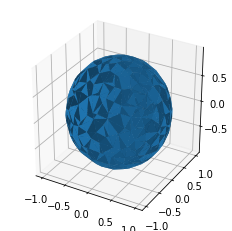

In [13]:
# Mesh and function space
#sphere = Sphere(Point(0.0, 0.0, 0.0), 1.0)
#vmesh = generate_mesh(sphere, 5)
#mesh = BoundaryMesh(vmesh, "exterior")
#plot(mesh)

#mesh = Mesh('LH/mesh.xml')
mesh = Mesh('LH/mesh_on_sphere_myself_b2000.xml')
plot(mesh)

In [14]:
for ind in nextIter_sub_indcs:
    print(ind)

0
32
33
36
37
39
40
44
45
46
47
49
52
53
54
55
60
61
62
64
65
66
67
70
71
72
73
74
76
77
78
80
82
83
85
86
87
88
89
90
92
93
94
97
98


In [15]:
for ind in sorted_true_sub_indcs:
    print(ind)

0
32
33
36
37
39
44
45
46
47
49
52
53
54
55
60
61
62
64
65
66
67
70
71
72
73
74
76
77
78
80
82
83
85
86
87
88
89
90
92
93
94
97
98


In [16]:
left_indcs

40

In [17]:
# Optimization options for the form compiler
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["optimize"] = True

In [18]:
# Make mesh ghosted for evaluation of DG terms
parameters["ghost_mode"] = "shared_facet"

In [19]:
bvec_volPredict = bvecs[left_indcs]
lh_coefs = np.zeros(len(sorted_true_sub_indcs))

for l in range(len(sorted_true_sub_indcs)):
    if sorted_true_sub_indcs[l] != 0:
        V = FunctionSpace(mesh, "P", 1)
        # get coordinates of DOFs
        dof_coords = V.tabulate_dof_coordinates()
        
        bcs = []
        for ind in sorted_true_sub_indcs:
            if ind!=0:
                if ind==sorted_true_sub_indcs[l]:
                    # find nearest DOF:
                    dof = np.argmin(np.linalg.norm(dof_coords - bvecs[ind], axis=1))
                    #print('dof {}, x = {}'.format(dof, dof_coords[dof]))
                    dof_sym = np.argmin(np.linalg.norm(dof_coords + bvecs[ind], axis=1))
                    #print('dof {}, x = {}'.format(dof_sym, dof_coords[dof_sym])) 

                    # now define a DirichletBC at that point
                    bcs.extend([DirichletBC(V, Constant(1.0),
                                     'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof][0], y=dof_coords[dof][1], z=dof_coords[dof][2]),
                                     'pointwise'),
                                DirichletBC(V, Constant(1.0),
                                     'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof_sym][0], y=dof_coords[dof_sym][1], z=dof_coords[dof_sym][2]),
                                     'pointwise')])
                else:
                    # find nearest DOF:
                    dof = np.argmin(np.linalg.norm(dof_coords - bvecs[ind], axis=1))
                    #print('dof {}, x = {}'.format(dof, dof_coords[dof]))
                    dof_sym = np.argmin(np.linalg.norm(dof_coords + bvecs[ind], axis=1))
                    #print('dof {}, x = {}'.format(dof_sym, dof_coords[dof_sym])) 

                    # now define a DirichletBC at that point
                    bcs.extend([DirichletBC(V, Constant(0.0),
                                     'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof][0], y=dof_coords[dof][1], z=dof_coords[dof][2]),
                                     'pointwise'),
                                DirichletBC(V, Constant(0.0),
                                     'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof_sym][0], y=dof_coords[dof_sym][1], z=dof_coords[dof_sym][2]),
                                     'pointwise')])
                    
        # Define trial and test functions
        u = TrialFunction(V)
        v = TestFunction(V)

        # Define normal component, mesh size and right-hand side
        h = CellDiameter(mesh)
        h_avg = (h('+') + h('-'))/2.0
        n = FacetNormal(mesh)
        f = Constant(0.0)

        # Penalty parameter
        alpha = Constant(8.0)
        # Define bilinear form
        a = inner(div(grad(u)), div(grad(v)))*dx \
          - inner(avg(div(grad(u))), jump(grad(v), n))*dS \
          - inner(jump(grad(u), n), avg(div(grad(v))))*dS \
          + alpha/h_avg*inner(jump(grad(u),n), jump(grad(v),n))*dS

        # Define linear form
        L = f*v*dx

        # Solve variational problem
        w = Function(V)
        solve(a == L, w, bcs)
        
        lh_coefs[l] = w(bvec_volPredict)
        print(lh_coefs[l])
    else:
        lh_coefs[l] = 0

0.2160949395938805
-0.00013754249766848706
0.0005375647974199492
0.0024616094644207163
0.0008069791507089906
0.002791797610854939
0.0004481508636972505
0.006748658730750384
0.06110077722897603
-0.034661623039242376
-0.04679952923972829
0.009871184018130983
0.2871522034323996
0.17375905184111484
-0.0003762398786222694
0.0015502911880136082
0.515229296737042
-0.06243361583122772
0.002895547188616151
-0.012824467045031668
-0.00026260210655017235
0.003550678756246238
-0.05464096978014969
0.2791558032140911
0.007552387674799563
-0.0016068995261637822
-0.016864329371327053
-5.9452199682777596e-05
-0.030959354068013995
-0.003103484900426652
0.001834959750629487
-0.0032252652139234434
-0.05213941150943493
-0.00012732187041994083
-0.03622795782627801
0.0002614303920622811
-0.06574302554994453
0.0033132898682118046
0.00039023555605128396
-0.0020741132627056435
-0.00016169485675540942
-0.155922463582887
0.00284452609806469


In [20]:
lh_coefs

array([ 0.00000000e+00,  2.16094940e-01, -1.37542498e-04,  5.37564797e-04,
        2.46160946e-03,  8.06979151e-04,  2.79179761e-03,  4.48150864e-04,
        6.74865873e-03,  6.11007772e-02, -3.46616230e-02, -4.67995292e-02,
        9.87118402e-03,  2.87152203e-01,  1.73759052e-01, -3.76239879e-04,
        1.55029119e-03,  5.15229297e-01, -6.24336158e-02,  2.89554719e-03,
       -1.28244670e-02, -2.62602107e-04,  3.55067876e-03, -5.46409698e-02,
        2.79155803e-01,  7.55238767e-03, -1.60689953e-03, -1.68643294e-02,
       -5.94521997e-05, -3.09593541e-02, -3.10348490e-03,  1.83495975e-03,
       -3.22526521e-03, -5.21394115e-02, -1.27321870e-04, -3.62279578e-02,
        2.61430392e-04, -6.57430255e-02,  3.31328987e-03,  3.90235556e-04,
       -2.07411326e-03, -1.61694857e-04, -1.55922464e-01,  2.84452610e-03])

In [21]:
len(lh_coefs[lh_coefs>0.01])

6

In [22]:
len(lh_coefs[lh_coefs<-0.01])

11

In [23]:
np.sum(lh_coefs)

0.9999999999999988

In [24]:
V = FunctionSpace(mesh, "P", 1)

# get coordinates of DOFs
dof_coords = V.tabulate_dof_coordinates()
bcs = []

for i in range(dof_coords.shape[0]):
    # find nearest DOF:
    dof = np.argmin(np.linalg.norm(dof_coords - dof_coords[i], axis=1))
    # now define a DirichletBC at that point
    bcs.extend([DirichletBC(V, Constant(0.0),
                       'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof][0], y=dof_coords[dof][1], z=dof_coords[dof][2]),
                                     'pointwise')])
           

for l in range(len(lh_coefs)):
    ind = sorted_true_sub_indcs[l]
    # find nearest DOF:
    dof = np.argmin(np.linalg.norm(dof_coords - bvecs[ind], axis=1))
    #print('dof {}, x = {}'.format(dof, dof_coords[dof]))
    dof_sym = np.argmin(np.linalg.norm(dof_coords + bvecs[ind], axis=1))
    #print('dof {}, x = {}'.format(dof_sym, dof_coords[dof_sym])) 

    # now define a DirichletBC at that point
    bcs.extend([DirichletBC(V, Constant(lh_coefs[l]),
                       'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof][0], y=dof_coords[dof][1], z=dof_coords[dof][2]),
                                     'pointwise'),
                DirichletBC(V, Constant(lh_coefs[l]),
                        'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof_sym][0], y=dof_coords[dof_sym][1], z=dof_coords[dof_sym][2]),
                           'pointwise')])
               
u = TrialFunction(V) 
v = TestFunction(V)
w1 = Function(V)   
a=inner(grad(u),grad(v))*dx
#a=Constant(0.0) 
        
f = Constant(0.0)
L = f*v*dx
solve(a == L, w1, bcs)

In [25]:
dof_coords.shape

(414, 3)

In [26]:
# Save solution to file in VTK format
vtkfile = File('multi_shell/solution.pvd')
vtkfile << w1

In [27]:
#inpaintedImg_3D = np.zeros((dims[0], dims[1], dims[2]))

#for i in range(len(sorted_true_sub_indcs)):
#    inpaintedImg_3D = inpaintedImg_3D + lh_coefs[i]*data_float[...,sorted_true_sub_indcs[i]]
#    #inpaintedImg_3D = inpaintedImg_3D + lh_coefs[i]*sub_regis_data[...,i]
#inpaintedImg_3D = inpaintedImg_3D/np.sum(lh_coefs)

In [28]:
#ni_img = nib.Nifti1Image(inpaintedImg_3D, affine=affine)
#nib.save(ni_img, "multi_shell/multi_fast_qspace_BH_volume_image_on_sphere_34_dely_P1.nii")

In [29]:
array_u = nodal_values_u = w1.vector()
vertex_values_u = w1.compute_vertex_values()

In [30]:
print(array_u)

In [31]:
for i in range(len(array_u)):
    print(array_u[i])

0.0
0.0
0.0
0.0
0.0
0.0
0.002791797610854939
0.0
-0.0003762398786222694
0.0
0.0
0.0002614303920622811
0.0
0.0
0.0
0.0
-5.9452199682777596e-05
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.012824467045031668
-0.06574302554994453
0.0
0.0
0.0
0.0008069791507089906
0.0
0.0
0.0
0.0
0.0
0.0
-0.016864329371327053
0.0
0.006748658730750384
0.0
0.0
0.0
0.0
0.0
-0.00013754249766848706
0.0
0.0
0.0
0.002895547188616151
0.0
0.0
0.0
-0.0020741132627056435
0.0
0.0
0.0
0.0
0.0
0.0
0.2791558032140911
-0.03622795782627801
0.0
0.009871184018130983
0.0
0.007552387674799563
-0.034661623039242376
0.0
0.0
0.0
0.0
0.0
0.003550678756246238
0.0
0.0
0.0
0.00284452609806469
0.0
0.0
0.0
-0.155922463582887
0.0
0.0
0.0
0.0
0.0
0.06110077722897603
0.0
-0.06243361583122772
0.0
0.0
0.0
0.0
0.0
-0.00026260210655017235
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.05464096978014969
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.00039023555605128396
-0.003103484900426652
0.0
-0.05213941150943493
0.0
0.0
0.515229296737042
0.0
0.0
0.0
0.0
0.28

In [32]:
min(array_u)

-0.155922463582887

In [33]:
len(array_u)

414

In [34]:
bvecs[1][0]

0.22293058

In [35]:
bvecs[1][2]

0.83703119

In [36]:
data_float[63,54,30,1]

43.0

In [37]:
data_float[63,54,30,14]

46.0

In [38]:
data_float[63,54,30,17]

13.0

In [39]:
data_float[63,54,30,20]

48.0

In [40]:
data_float[63,54,30,22]

25.0

In [41]:
data_float[63,54,30,29]

52.0

In [42]:
#error_L2 = errornorm(u_D, w, 'L2')
#vertex_values_u_D = u_D.compute_vertex_values(mesh)
#vertex_values_u = w.compute_vertex_values(mesh)
#error_max = np.max(np.abs(vertex_values_u_D - vertex_values_u))
#print(error_max)
#print(error_L2)

In [43]:
bvecs[27]

array([-0.70739847,  0.15345097,  0.68995672])

In [44]:
x_point = Point(*[bvecs[27]])
mesh.bounding_box_tree().compute_first_entity_collision(x_point)

4294967295

In [45]:
#mesh.bounding_box_tree().compute_closest_point(x_point)

In [46]:
inpaintedImg_3D.shape

NameError: name 'inpaintedImg_3D' is not defined

In [ ]:
max(inpaintedImg_3D.flatten())